Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 83s 445ms/step - accuracy: 0.6267 - loss: 1.0058 - val_accuracy: 0.7906 - val_loss: 0.5602 - learning_rate: 0.0010
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.8125 - loss: 0.5677 - val_accuracy: 0.8000 - val_loss: 0.5482 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 76s 427ms/step - accuracy: 0.8152 - loss: 0.4844 - val_accuracy: 0.8313 - val_loss: 0.5255 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.8438 - loss: 0.3550 - val_accuracy: 0.8273 - val_loss: 0.5376 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 75s 422ms/step - accuracy: 0.8576 - loss: 0.3813 - val_accuracy: 0.8398 - val_loss: 0.4467 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.8750 - loss: 0.2795 - val_accuracy: 0.8406 - val_loss: 0.4483 - learning_ra

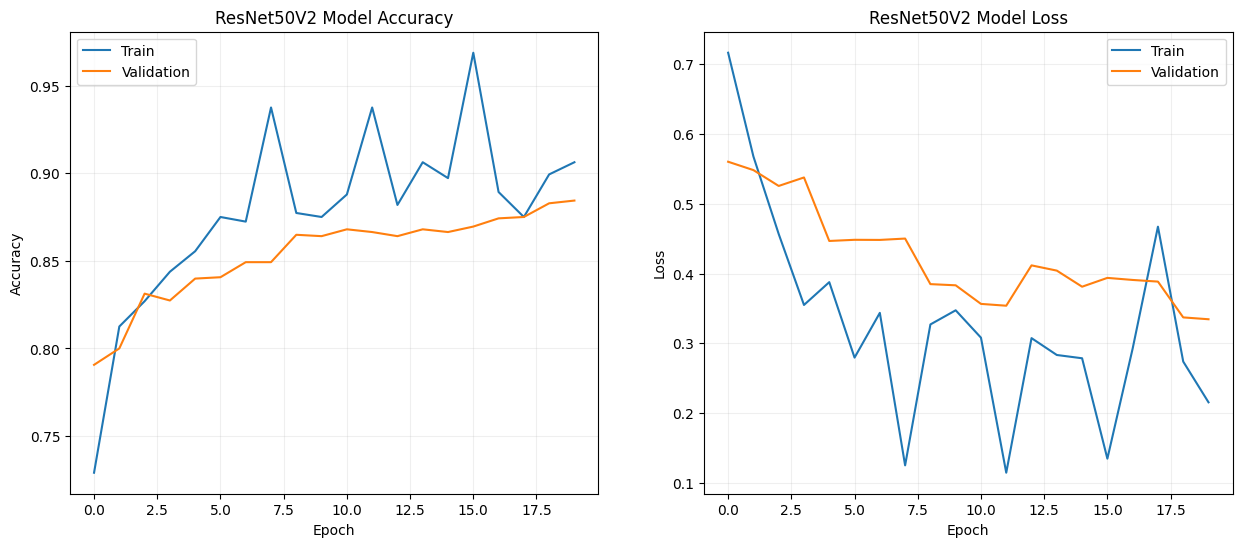

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 388ms/step


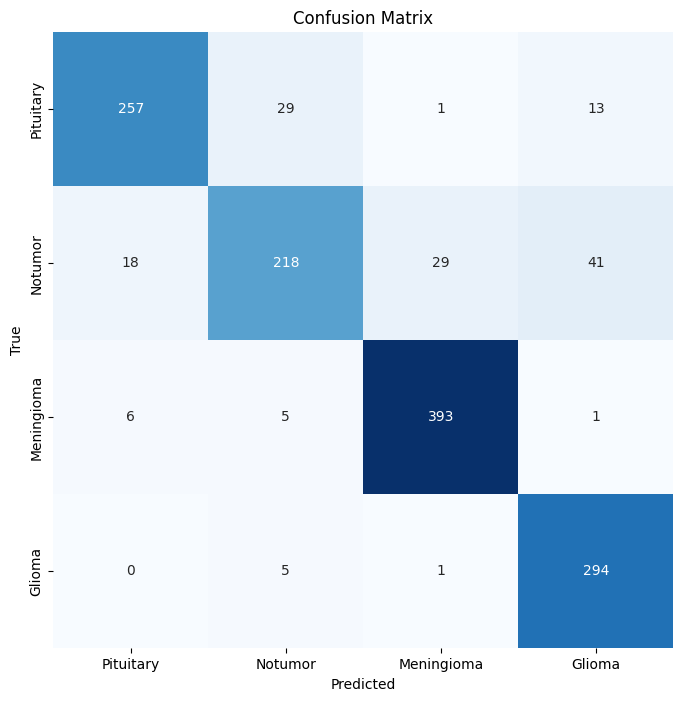

Class: Pituitary
Precision: 0.915
Recall: 0.857
F1-Score: 0.885

Class: Notumor
Precision: 0.848
Recall: 0.712
F1-Score: 0.774

Class: Meningioma
Precision: 0.927
Recall: 0.970
F1-Score: 0.948

Class: Glioma
Precision: 0.842
Recall: 0.980
F1-Score: 0.906


Accuracy: 0.886


In [2]:
# Complete working code to replace custom CNN with ResNet50V2 for Brain Tumour Detection
# This code keeps the input shape and tech stack same as original notebook

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import random
import os

# Set seed for reproducibility
SEED = 111
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Global variables
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)
image_size = (150, 150)
batch_size = 32
epochs = 40

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

# Paths (update USER_PATH as needed)
USER_PATH = r"D:/6th Sem Projects/brain-tumor-mri-dataset"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

steps_per_epoch = train_generator.samples // batch_size
validation_steps = test_generator.samples // batch_size

# Define the ResNet50V2 based model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_resnet50v2_model(input_shape=(150, 150, 3), num_classes=4):
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers initially

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_resnet50v2_model(input_shape=(150, 150, 3), num_classes=N_TYPES)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=validation_steps)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

# Plot training history
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('ResNet50V2 Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('ResNet50V2 Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

# Confusion matrix and metrics
def CM(model, test_generator, categories):
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    return confusion_matrix_array

def calculate_metrics(confusion_matrix, categories):
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    print(f"\nAccuracy: {accuracy:.3f}")

confusion_matrix = CM(model, test_generator, CLASS_TYPES)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in CLASS_TYPES], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in CLASS_TYPES], va='center')
plt.show()

calculate_metrics(confusion_matrix, CLASS_TYPES)


In [4]:
model.save('brain_tumor_resnet50v2_model.keras')

# Save class labels for inference
import json
class_labels = CLASS_TYPES  # ['pituitary', 'notumor', 'meningioma', 'glioma']
with open('class_labels.json', 'w') as f:
    json.dump(class_labels, f)